# Imports

In [1]:
from utils import Options, transfer

# Transfer

In [2]:
opt = Options(phase="test", img_size=256, dataroot="dataset2/images", dirmap="dataset2/parsing", save_path="results/")

loaded trained generator ./checkpoints/G.pth..!


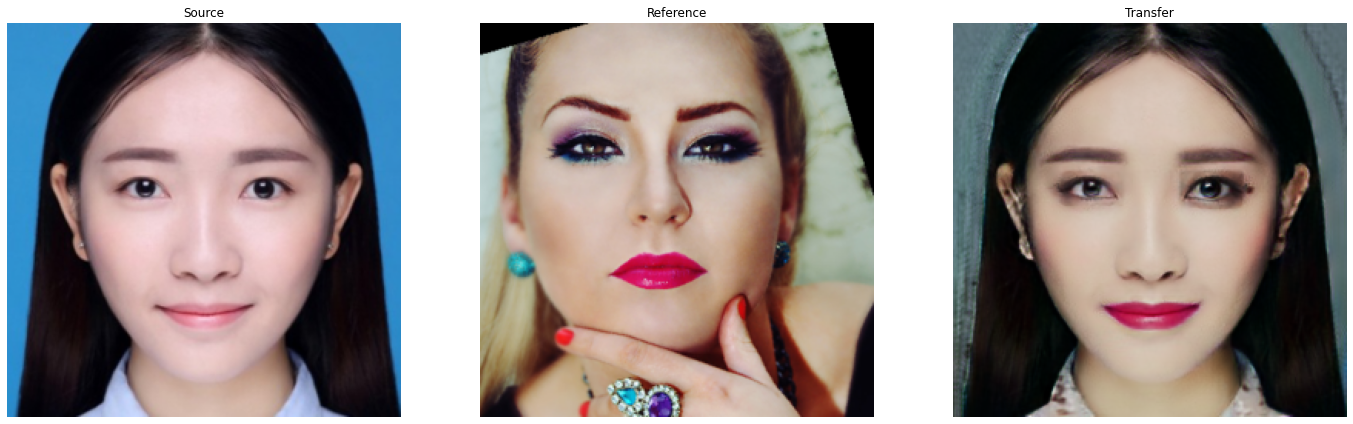

In [3]:
results = transfer(source_path="dataset/non-makeup/00295.jpg", 
                   reference_path="dataset/makeup/b7fd5266d01609248414333cdf0735fae6cd34e7.png", 
                   opt=opt)

loaded trained generator ./checkpoints/G.pth..!


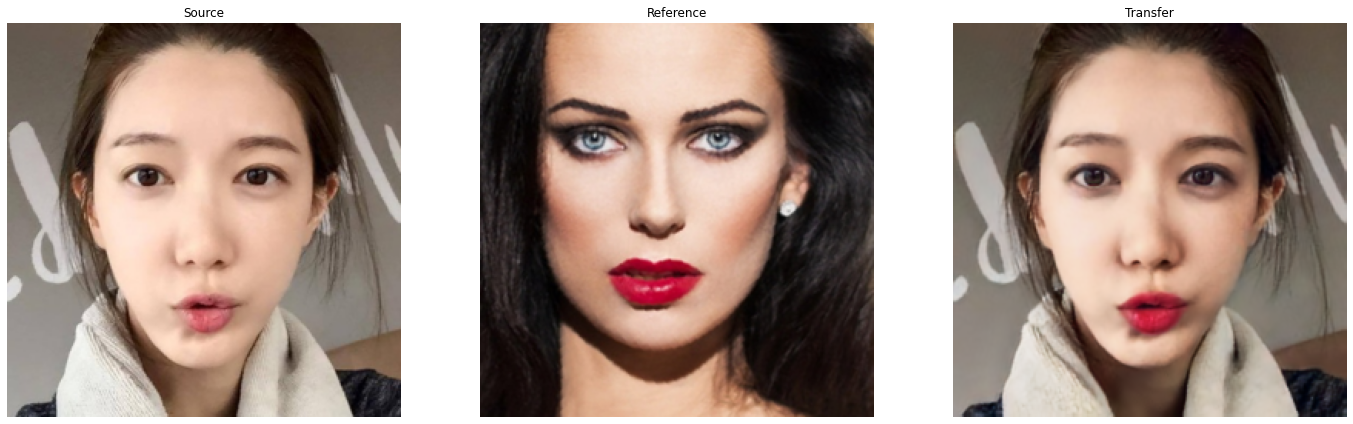

In [4]:
results = transfer(source_path="dataset/non-makeup/00290.jpg", 
                   reference_path="dataset/makeup/XMY-078.png", 
                   opt=opt)